In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, mnist_transform
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

In [33]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

train_length = 1000
train_data = datasets.MNIST('./MNIST_data', train=True, download=True, transform=mnist_transform)
train_loader = DataLoader(train_data, batch_size=50, sampler=SubsetRandomSampler( np.arange(train_length) ))

In [34]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.SGD(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [35]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
        
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [36]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [37]:
def plot_train_test(train_log, test_log):
    data = {}
    for name, model in train_log.items():
        train_name = '{}_train'.format(name)
        test_name = '{}_test'.format(name)
        data[train_name] = model
        data[test_name] = test_log[name]
    
    plot_graphs(data, 'loss')
    plot_graphs(data, 'accuracy')

In [38]:
#models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
models = {'default': Net(False, False, lr=1e-3)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [55]:
%%time

for model in models.values():
    for g in model.optim.param_groups:
        g['lr'] = 1e-2

for epoch in range(0, 20):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, train_loader, train_log)
    test(models, valid_loader, test_log)

Train Epoch: 0 [0/1000 (0%)]	Losses default: 0.011769
Train Epoch: 0 [1000/1000 (100%)]	Losses default: 0.008819
Test set:
default: Loss: 0.0146	Accuracy: 1000.0/1000 (100%)

Test set:
default: Loss: 0.4446	Accuracy: 8715.0/10000 (87%)

Train Epoch: 1 [0/1000 (0%)]	Losses default: 0.011448
Train Epoch: 1 [1000/1000 (100%)]	Losses default: 0.012198
Test set:
default: Loss: 0.0145	Accuracy: 1000.0/1000 (100%)

Test set:
default: Loss: 0.4447	Accuracy: 8717.0/10000 (87%)

Train Epoch: 2 [0/1000 (0%)]	Losses default: 0.016927
Train Epoch: 2 [1000/1000 (100%)]	Losses default: 0.013175
Test set:
default: Loss: 0.0144	Accuracy: 1000.0/1000 (100%)

Test set:
default: Loss: 0.4448	Accuracy: 8717.0/10000 (87%)

Train Epoch: 3 [0/1000 (0%)]	Losses default: 0.011554
Train Epoch: 3 [1000/1000 (100%)]	Losses default: 0.016340
Test set:
default: Loss: 0.0144	Accuracy: 1000.0/1000 (100%)

Test set:
default: Loss: 0.4451	Accuracy: 8716.0/10000 (87%)

Train Epoch: 4 [0/1000 (0%)]	Losses default: 0.01486

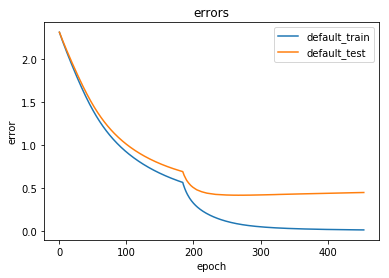

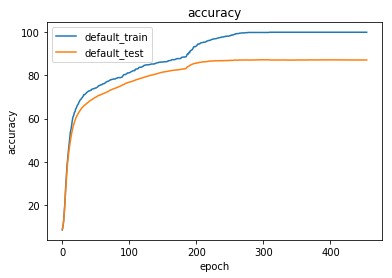

In [56]:
# ускорение падения ошибки на графике - результат того, что я увеличил learning rate
plot_train_test(train_log, test_log)

In [57]:
test_log

{'default': [(2.3086791793823243, 8.75),
  (2.288126535797119, 10.21),
  (2.267877855682373, 12.46),
  (2.247907730102539, 16.28),
  (2.2281944564819334, 21.1),
  (2.208719068145752, 26.52),
  (2.189462299346924, 31.7),
  (2.170403385925293, 36.02),
  (2.151524398803711, 39.75),
  (2.1328068862915037, 42.7),
  (2.1142418632507325, 45.32),
  (2.0958107025146484, 47.62),
  (2.0775036911010742, 49.61),
  (2.0593101402282716, 51.58),
  (2.0412220001220702, 53.25),
  (2.023232898712158, 54.8),
  (2.0053410232543945, 56.12),
  (1.987532918548584, 57.31),
  (1.9698094978332519, 58.26),
  (1.9521678993225098, 59.21),
  (1.9346107788085938, 60.09),
  (1.917132614135742, 60.78),
  (1.89973924407959, 61.45),
  (1.8824340629577636, 61.97),
  (1.8652140571594238, 62.63),
  (1.8480853897094727, 63.05),
  (1.8310516975402833, 63.51),
  (1.814124942779541, 63.97),
  (1.7973015701293946, 64.46),
  (1.7805782752990722, 64.91),
  (1.7639784774780274, 65.26),
  (1.7475027618408203, 65.55),
  (1.7311528511